In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import time
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torchvision.models import (
    resnet50, ResNet50_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    densenet121, DenseNet121_Weights
)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Enable cuDNN tuning for speedup
torch.backends.cudnn.benchmark = True

# Dataset paths (Update these paths)
train_dir = "/content/drive/MyDrive/Image_dataset/train"
val_dir   = "/content/drive/MyDrive/Image_dataset/val"


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [6]:
# ✅ Custom Dataset Wrapper for Binary Classification
class BinaryPhishingDataset(ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        folder_name = self.classes[label]
        binary_label = 0 if folder_name == "other" else 1
        return image, binary_label



In [7]:
# ✅ Load datasets
train_dataset = BinaryPhishingDataset(train_dir, transform=transform)
val_dataset = BinaryPhishingDataset(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)



In [8]:
print(f"Total training images: {len(train_dataset)}")
print(f"Total testing images:  {len(val_dataset)}")

Total training images: 1313
Total testing images:  1539


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def train_model(model, train_loader, val_loader, device, num_epochs=5, model_name="Model"):
    """
    Trains and evaluates a model with classification metrics and confusion matrix.

    Returns: dict with model, metrics, predictions, and confusion matrix
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total * 100
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(all_labels, all_preds, target_names=["Legitimate", "Phishing"]))

    print(f"\n✅ Summary for {model_name}:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")

    return {
        "model": model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "confusion_matrix": cm,
        "predictions": all_preds,
        "labels": all_labels
    }

In [10]:
# ResNet50
model_res = resnet50(weights=ResNet50_Weights.DEFAULT)
model_res.fc = nn.Linear(model_res.fc.in_features, 2)

# EfficientNet-B0
model_eff = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 2)

# DenseNet121
model_den = densenet121(weights=DenseNet121_Weights.DEFAULT)
model_den.classifier = nn.Linear(model_den.classifier.in_features, 2)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 229MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


In [11]:
# Train and evaluate each model
start = time.time()
resnet_result = train_model(model_res, train_loader, val_loader, device, model_name="ResNet50")
print(f"⏱️ ResNet50 took {time.time() - start:.2f} seconds\n")


[ResNet50] Epoch 1/5, Loss: 21.1756, Accuracy: 76.39%
[ResNet50] Epoch 2/5, Loss: 8.7077, Accuracy: 93.30%
[ResNet50] Epoch 3/5, Loss: 2.6458, Accuracy: 99.01%
[ResNet50] Epoch 4/5, Loss: 2.1230, Accuracy: 99.77%
[ResNet50] Epoch 5/5, Loss: 0.7862, Accuracy: 99.92%

📊 Classification Report for ResNet50:

              precision    recall  f1-score   support

  Legitimate       0.98      0.86      0.91      1000
    Phishing       0.78      0.96      0.86       539

    accuracy                           0.89      1539
   macro avg       0.88      0.91      0.89      1539
weighted avg       0.91      0.89      0.90      1539


✅ Summary for ResNet50:
Accuracy :  0.8941
Precision:  0.7848
Recall   :  0.9610
F1 Score :  0.8641
⏱️ ResNet50 took 1239.85 seconds



In [12]:

start = time.time()
effnet_result = train_model(model_eff, train_loader, val_loader, device, model_name="EfficientNet-B0")
print(f"⏱️ EfficientNet-B0 took {time.time() - start:.2f} seconds\n")


[EfficientNet-B0] Epoch 1/5, Loss: 23.9176, Accuracy: 73.50%
[EfficientNet-B0] Epoch 2/5, Loss: 15.1756, Accuracy: 88.19%
[EfficientNet-B0] Epoch 3/5, Loss: 8.6073, Accuracy: 93.83%
[EfficientNet-B0] Epoch 4/5, Loss: 5.2383, Accuracy: 96.19%
[EfficientNet-B0] Epoch 5/5, Loss: 3.2531, Accuracy: 98.40%

📊 Classification Report for EfficientNet-B0:

              precision    recall  f1-score   support

  Legitimate       0.98      0.84      0.90      1000
    Phishing       0.76      0.97      0.86       539

    accuracy                           0.88      1539
   macro avg       0.87      0.91      0.88      1539
weighted avg       0.91      0.88      0.89      1539


✅ Summary for EfficientNet-B0:
Accuracy :  0.8850
Precision:  0.7631
Recall   :  0.9740
F1 Score :  0.8557
⏱️ EfficientNet-B0 took 100.96 seconds



In [13]:
start = time.time()
densenet_result = train_model(model_den, train_loader, val_loader, device, model_name="DenseNet121")
print(f"⏱️ DenseNet121 took {time.time() - start:.2f} seconds\n")

[DenseNet121] Epoch 1/5, Loss: 18.8230, Accuracy: 79.74%
[DenseNet121] Epoch 2/5, Loss: 6.1261, Accuracy: 95.66%
[DenseNet121] Epoch 3/5, Loss: 3.4917, Accuracy: 99.62%
[DenseNet121] Epoch 4/5, Loss: 1.1632, Accuracy: 99.92%
[DenseNet121] Epoch 5/5, Loss: 2.0708, Accuracy: 99.92%

📊 Classification Report for DenseNet121:

              precision    recall  f1-score   support

  Legitimate       0.99      0.80      0.88      1000
    Phishing       0.72      0.98      0.83       539

    accuracy                           0.86      1539
   macro avg       0.86      0.89      0.86      1539
weighted avg       0.89      0.86      0.87      1539


✅ Summary for DenseNet121:
Accuracy :  0.8622
Precision:  0.7249
Recall   :  0.9777
F1 Score :  0.8325
⏱️ DenseNet121 took 106.22 seconds



In [14]:

# ✅ Extract F1 scores from the returned results
f1_resnet = resnet_result["f1_score"]
f1_eff    = effnet_result["f1_score"]
f1_den    = densenet_result["f1_score"]

In [15]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ✅ Compute weights based on F1-scores
total_f1 = f1_resnet + f1_eff + f1_den
w_res = f1_resnet / total_f1
w_eff = f1_eff / total_f1
w_den = f1_den/ total_f1

print(f"Voting Weights → ResNet: {w_res:.2f}, EfficientNet: {w_eff:.2f}, DenseNet: {w_den:.2f}")

# ✅ Weighted Soft Voting
all_preds_voting = []
all_labels_voting = []

model_res.eval()
model_eff.eval()
model_den.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        all_labels_voting.extend(labels.cpu().numpy())

        prob_res = F.softmax(model_res(inputs), dim=1)
        prob_eff = F.softmax(model_eff(inputs), dim=1)
        prob_den = F.softmax(model_den(inputs), dim=1)

        # ✅ Weighted average of probabilities
        avg_prob = (w_res * prob_res + w_eff * prob_eff + w_den * prob_den)
        final_preds = torch.argmax(avg_prob, dim=1)

        all_preds_voting.extend(final_preds.cpu().numpy())

Voting Weights → ResNet: 0.34, EfficientNet: 0.34, DenseNet: 0.33


In [16]:
print("\n📊 Classification Report (Weighted Soft Voting):")
print(classification_report(all_labels_voting, all_preds_voting, target_names=["Legitimate", "Phishing"]))

print("\n✅ Summary Metrics (Weighted Voting):")
print(f"Accuracy :  {accuracy_score(all_labels_voting, all_preds_voting):.4f}")
print(f"Precision:  {precision_score(all_labels_voting, all_preds_voting):.4f}")
print(f"Recall   :  {recall_score(all_labels_voting, all_preds_voting):.4f}")
print(f"F1 Score :  {f1_score(all_labels_voting, all_preds_voting):.4f}")


📊 Classification Report (Weighted Soft Voting):
              precision    recall  f1-score   support

  Legitimate       0.99      0.85      0.92      1000
    Phishing       0.78      0.98      0.87       539

    accuracy                           0.90      1539
   macro avg       0.88      0.92      0.89      1539
weighted avg       0.92      0.90      0.90      1539


✅ Summary Metrics (Weighted Voting):
Accuracy :  0.8973
Precision:  0.7822
Recall   :  0.9796
F1 Score :  0.8699


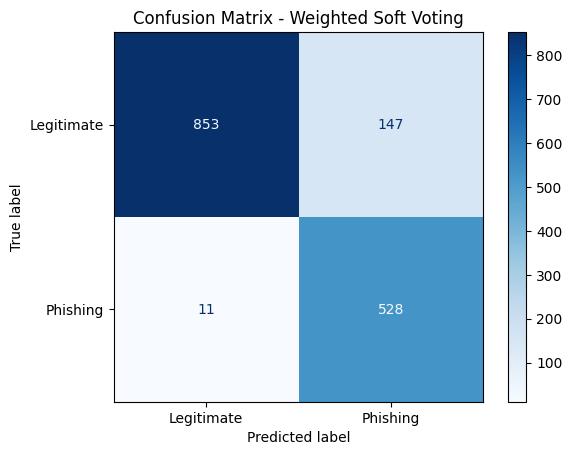

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_weighted = confusion_matrix(all_labels_voting, all_preds_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Weighted Soft Voting")
plt.show()

In [18]:
torch.save(model_res.state_dict(), "resnet50_image.pth")
torch.save(model_eff.state_dict(), "efficientnet_b0_image.pth")
torch.save(model_den.state_dict(), "densenet121_image.pth")

In [19]:
import torch
import torch.nn.functional as F

class ImageFusionWrapper:
    def __init__(self, model_paths, f1_scores, device):
        from torchvision.models import resnet50, efficientnet_b0, densenet121
        from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, DenseNet121_Weights
        import torch.nn as nn

        self.device = device
        self.f1_scores = f1_scores
        self.weights = [f / sum(f1_scores) for f in f1_scores]

        # Load models from paths
        self.models = []

        # ResNet50
        model_res = resnet50(weights=None)
        model_res.fc = nn.Linear(model_res.fc.in_features, 2)
        model_res.load_state_dict(torch.load(model_paths[0], map_location=device))
        model_res.to(device).eval()
        self.models.append(model_res)

        # EfficientNet-B0
        model_eff = efficientnet_b0(weights=None)
        model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 2)
        model_eff.load_state_dict(torch.load(model_paths[1], map_location=device))
        model_eff.to(device).eval()
        self.models.append(model_eff)

        # DenseNet121
        model_den = densenet121(weights=None)
        model_den.classifier = nn.Linear(model_den.classifier.in_features, 2)
        model_den.load_state_dict(torch.load(model_paths[2], map_location=device))
        model_den.to(device).eval()
        self.models.append(model_den)

    def predict(self, dataloader):
        all_preds = []
        with torch.no_grad():
            for inputs in dataloader:
                if isinstance(inputs, (tuple, list)):
                    inputs = inputs[0]
                inputs = inputs.to(self.device)
                probs = [F.softmax(m(inputs), dim=1) for m in self.models]
                avg_prob = sum(w * p for w, p in zip(self.weights, probs))
                preds = torch.argmax(avg_prob, dim=1)
                all_preds.extend(preds.cpu().numpy())
        return all_preds

In [20]:
import joblib

# Provide your actual paths and F1-scores here
model_paths = [
    "resnet50_image.pth",
    "efficientnet_b0_image.pth",
    "densenet121_image.pth"
]

f1_scores = [f1_resnet, f1_eff, f1_den]  # Use your actual values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the fusion model
image_fusion_model = ImageFusionWrapper(model_paths, f1_scores, device)

# Save the wrapper
joblib.dump(image_fusion_model, "image_fusion_model.pkl")
print("✅ Saved image fusion model as image_fusion_model.pkl")

✅ Saved image fusion model as image_fusion_model.pkl


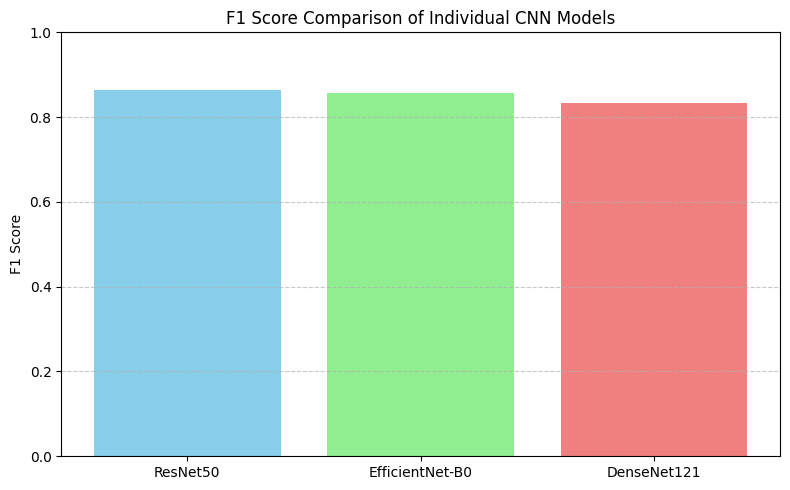

In [21]:
import matplotlib.pyplot as plt

# Example F1 scores (replace with your real values)
f1_scores = {
    "ResNet50": f1_resnet,
    "EfficientNet-B0": f1_eff,
    "DenseNet121": f1_den
}

plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison of Individual CNN Models")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

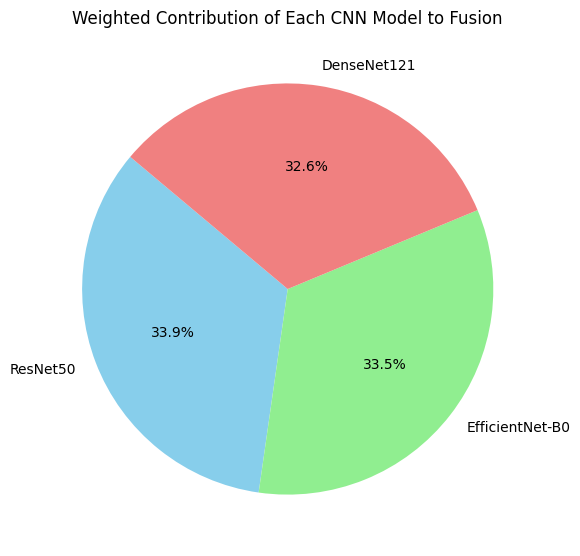

In [22]:
weights = [f / sum(f1_scores.values()) for f in f1_scores.values()]
labels = list(f1_scores.keys())

plt.figure(figsize=(6, 6))
plt.pie(weights, labels=labels, autopct="%1.1f%%", startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title("Weighted Contribution of Each CNN Model to Fusion")
plt.tight_layout()
plt.show()